<a href="https://colab.research.google.com/github/BeckMatthew/Scorigami/blob/main/scorigami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
Because of the unique scoring of American Football, where scoring most commonly occurs in intervals of 7 or 3 points (and more rarely, 2, 6, or 8), the final scores of NFL games tend to take on certain discrete values; some are incredibly common and occur thousands of times while others have yet to occur. NFL fans on the internet have tracked the occurance of NFL final scores and fans have given the name "scoirgami" to the event of a novel scoring combination occuring for the first time.

The below project attempts various machine learning techniques for predicting if an in-progress NFL game will end in a scorigami.

## Outline
1. Importing Libraries and dataset
2. Establishing baselines for prediction
3. Random Forest algorithm
4. Deep Neural Network
5. Pretraining DNN
5. Recurrant Neural Network

## 1. Importing Libraries and Dataset

In [1]:

# Load libraries
import numpy as np
from sklearn.model_selection import train_test_split

import math
from sklearn.metrics import precision_recall_curve,auc,average_precision_score
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

from tensorflow.keras import layers, regularizers
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

X is in the shape (6757, 60, 16). This corresponds to 6,757 NFL games occuring between the 2001 and 2025 season. In each game, 60 observations are made corresponding to each minute of gameplay in a regulation football game (not including overtime) of 16 features of interest corresponding to the cumulative number of different scoring plays that have occured in that game. The feature labels are contained in the file X_features.csv

y is an array of booleans representing whether each of the games would have been a scorigami had it occured in the 2001 season.

In [2]:
# Load dataset
# See getData.py for details on how dataset was obtained and cleaned

X = np.load('X.npy')
y = np.load('y.npy')
print(X.shape)
print(y.shape)

with open('X_features.csv', 'r') as f:
  print(f.read())

#Split into train/test/cross-validation

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.2)

(6757, 60, 16)
(6757, 1)
homeTds, awayTds, homePATs, awayPATs, home2Cvs, away2Cvs, homeFGs, awayFGs, homeSafeties, awaySafeties, totalSafeties, homeDef2ptConv, awayDef2ptConv, currentHome, currentAway, totalPoints, 


Features are recorded as "home" and "away" teams. However, for purposes of Scorigami, it does not matter if the teams are home or away; therefore, the X_train dataset is duplicated, reversing "home" and "away" teams.

In [3]:
X_train_r = np.ndarray(X_train.shape, float)

X_train_r[:, :, 0] = X_train[:, :, 1]
X_train_r[:, :, 1] = X_train[:, :, 0]
X_train_r[:, :, 2] = X_train[:, :, 3]
X_train_r[:, :, 3] = X_train[:, :, 2]
X_train_r[:, :, 4] = X_train[:, :, 5]
X_train_r[:, :, 5] = X_train[:, :, 4]
X_train_r[:, :, 6] = X_train[:, :, 7]
X_train_r[:, :, 7] = X_train[:, :, 6]
X_train_r[:, :, 8] = X_train[:, :, 9]
X_train_r[:, :, 9] = X_train[:, :, 8]
X_train_r[:, :, 10] = X_train[:, :, 10]
X_train_r[:, :, 11] = X_train[:, :, 12]
X_train_r[:, :, 12] = X_train[:, :, 11]
X_train_r[:, :, 13] = X_train[:, :, 14]
X_train_r[:, :, 14] = X_train[:, :, 13]
X_train_r[:, :, 15] = X_train[:, :, 15]

X_train = np.append(X_train, X_train_r, axis=0)
print(X_train.shape)
y_train = np.append(y_train, y_train, axis=0)
print(y_train.shape)


(10810, 60, 16)
(10810, 1)


To demonstrate predicting an in-progress NFL game, a "time snapshot" will be made at the 45th minute of the game. The X array will be a 2D array containing only observations of the interest features at the 45th minute of the game

In [4]:
time = 45
X_train_snapshot = X_train[:,time-1,:]
X_test_snapshot = X_test[:,time-1,:]

print(X_train_snapshot.shape)
print(X_test_snapshot.shape)

(10810, 16)
(1352, 16)


# 2. Baseline Models

To evaluate the performance of my machine learning models, I will create two different deterministic predictors as baseline comparisons. The first one predicts that a game will end in a scorigami if the current score would be a scorigami if the game ended immediately; the second predicts that the game will end in a scorigami if the current score is 2 SD above the mean (high scoring games are more likely to be scorigami).

In [5]:
# import isScorigami function used in Current Scorigami Predictor
!wget https://github.com/liam-moyer/Scorigami-Modeling/raw/refs/heads/main/EveryScorigami.xlsx
!pip install fastexcel
from isScorigami import isScorigami

#Current Scorigami predictor: if a scorigami at time t, then predict scorigami
def currentscorigamiredictor(testSet):
  out = []
  for i in range(testSet.shape[0]):
    if isScorigami(testSet[i,13],testSet[i,14],2001):
      out.append(1)
    else:
      out.append(0)
  return out


meanTotalScore = np.average(X_train_snapshot[:,15])
stdTotalScore = np.std(X_train_snapshot[:,15])

  #Predict positive if home + away is more than 2 SD from mean
def scorepredictor(testSet):
  out = []
  for i in range(testSet.shape[0]):
    if testSet[i,15] > (meanTotalScore + 2*stdTotalScore):
      out.append(1)
    else:
      out.append(0)
  return out


--2026-02-05 19:59:57--  https://github.com/liam-moyer/Scorigami-Modeling/raw/refs/heads/main/EveryScorigami.xlsx
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/liam-moyer/Scorigami-Modeling/refs/heads/main/EveryScorigami.xlsx [following]
--2026-02-05 19:59:57--  https://raw.githubusercontent.com/liam-moyer/Scorigami-Modeling/refs/heads/main/EveryScorigami.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1326019 (1.3M) [application/octet-stream]
Saving to: ‘EveryScorigami.xlsx’

EveryScorigami.xlsx 100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2026-02-05 19:59:58 (19.7 MB

The metrics of the two baselines are shown below. Two different baselines were selected because they will perform differently at different time snapshots. Closer to the end of the football game, the "current scorigami" predictor will outperform the "high scoring" predictor.

In either case, neither predictor is particularly accurate considering the high variability of an NFL game.

AUCPR (trapezoidal) = 0.1735


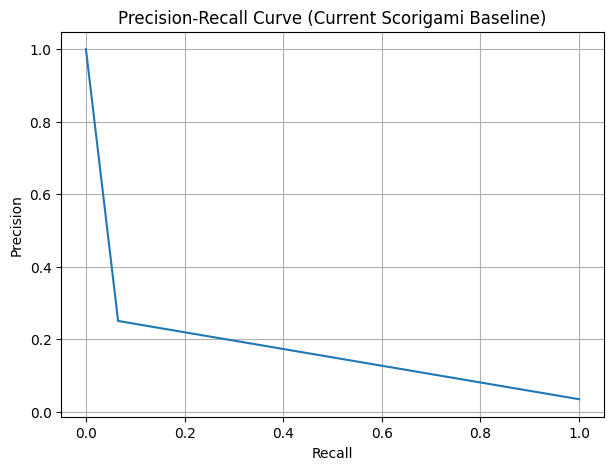

F1 score: 0.10344827586206896


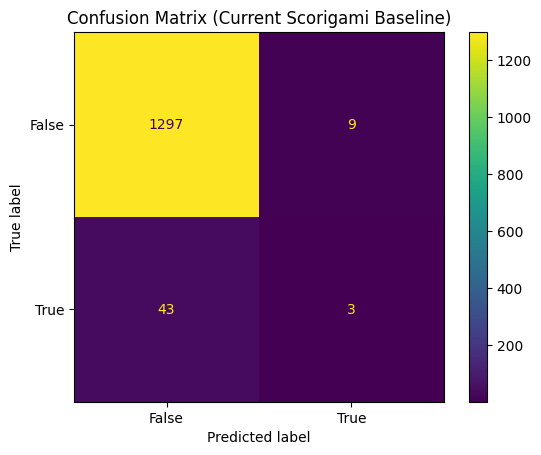

In [6]:
current_baseline_prediction = currentscorigamiredictor(X_test_snapshot)

precision_curbl,recall_curbl,thresholds_curbl = precision_recall_curve(y_test,current_baseline_prediction)
aucpr_curbl = auc(recall_curbl, precision_curbl)

print(f"AUCPR (trapezoidal) = {aucpr_curbl:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_curbl, precision_curbl)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Current Scorigami Baseline)")
plt.grid(True)
plt.show()

f1bl_current = f1_score(y_test,current_baseline_prediction)

print(f"F1 score: {f1bl_current}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,current_baseline_prediction)
plt.title("Confusion Matrix (Current Scorigami Baseline)")
plt.show()

AUCPR (trapezoidal) = 0.2010


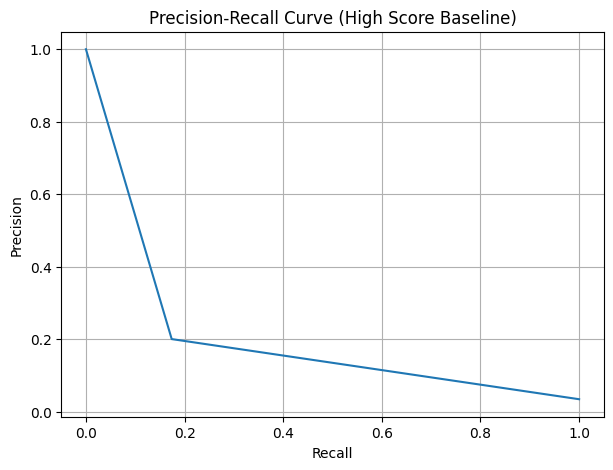

F1 score: 0.18604651162790697


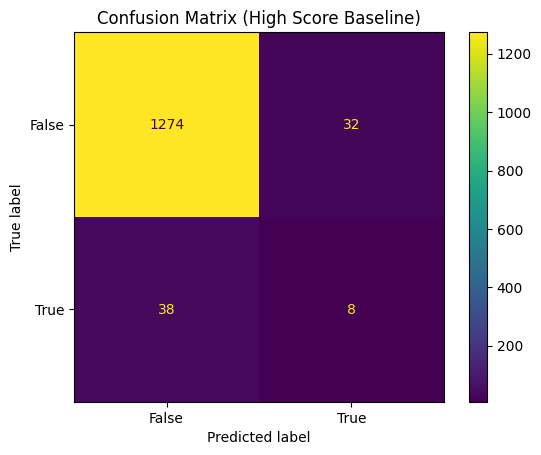

In [7]:
score_baseline_prediction = scorepredictor(X_test_snapshot)

precision_scorebl,recall_scorebl,thresholds_scorebl = precision_recall_curve(y_test,score_baseline_prediction)
aucpr_scorebl = auc(recall_scorebl, precision_scorebl)

print(f"AUCPR (trapezoidal) = {aucpr_scorebl:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_scorebl, precision_scorebl)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (High Score Baseline)")
plt.grid(True)
plt.show()

f1bl_score = f1_score(y_test,score_baseline_prediction)

print(f"F1 score: {f1bl_score}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,score_baseline_prediction)
plt.title("Confusion Matrix (High Score Baseline)")
plt.show()

## 2. Random Forest Model

Because of the high degree of class imbalance in this dataset, I will be using the Balanced Random Forest classifier through imbalanced-learn, which is in turn based on the random forest classifier in Scikit-Learn

In [36]:
#balanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(
    n_estimators=50000, sampling_strategy="all", replacement=True,
    bootstrap=False, warm_start=True, verbose=True, n_jobs=-1
)
brf.fit(X_train_snapshot, np.ravel(y_train))
predicted_brf = brf.predict(X_test_snapshot)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 11246 tasks  

### Results and Analysis



AUCPR (trapezoidal) = 0.3533


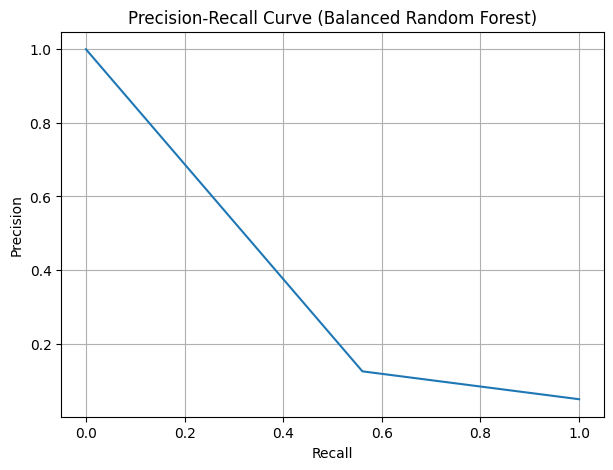

F1 score: 0.20385674931129477


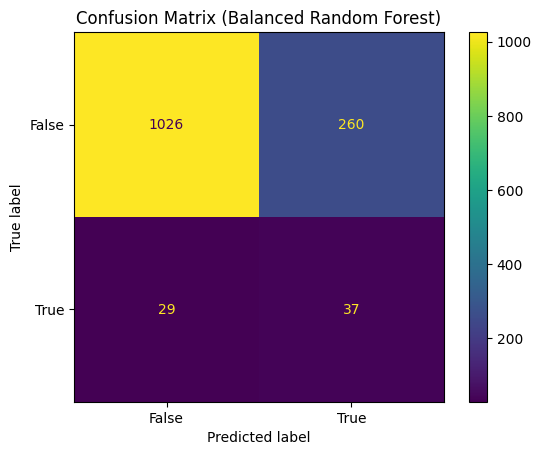

In [35]:
precision_brf,recall_brf,thresholds_brf = precision_recall_curve(y_test,predicted_brf)
aucpr_brf = auc(recall_brf, precision_brf)

print(f"AUCPR (trapezoidal) = {aucpr_brf:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_brf, precision_brf)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Balanced Random Forest)")
plt.grid(True)
plt.show()

f1brf = f1_score(y_test,predicted_brf)

print(f"F1 score: {f1brf}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,predicted_brf)
plt.title("Confusion Matrix (Balanced Random Forest)")
plt.show()

## 3. Artificial Neural Network

The hyperparameters used for this ANN were determined using hyperparameter tuning via a Bayseian search implemented in the Karas-tuner API. Full details on this can be found in the hyperameterTuning.py file.

In [8]:
# Import saved hyperparamters from csv; five best hyperparameters were saved
hyperparameters = []

import csv

with open('hyperparameters.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='|')
    for row in reader:
      hyperparameters.append(eval(str(row[0])))


for i in range(5):
  print(hyperparameters[i])


from tensorflow.keras import layers, regularizers
!pip install keras-tuner
import keras_tuner
from sklearn.metrics import f1_score


myhps = keras_tuner.HyperParameters()

myhps.values = hyperparameters[0]

{'n_hidden': 12, 'n_neurons': 407, 'l2_regularization': 3.337895988223092e-05, 'alpha': np.float64(0.8743610285304286), 'gamma': np.float64(6.0), 'learning_rate': 0.002007159607385987}
{'n_hidden': 14, 'n_neurons': 622, 'l2_regularization': 1.166017288523066e-13, 'alpha': np.float64(0.8681992895839716), 'gamma': np.float64(4.830626085760844), 'learning_rate': 0.00037554975176273993}
{'n_hidden': 13, 'n_neurons': 50, 'l2_regularization': 1.1306828518029739e-09, 'alpha': np.float64(0.8574131833442318), 'gamma': np.float64(4.994211832273153), 'learning_rate': 0.002040540358854104}
{'n_hidden': 18, 'n_neurons': 50, 'l2_regularization': 1e-14, 'alpha': np.float64(0.8736307751957697), 'gamma': np.float64(3.3176633899979984), 'learning_rate': 0.0015516231079206115}
{'n_hidden': 20, 'n_neurons': 50, 'l2_regularization': 9.095336643283512e-09, 'alpha': np.float64(0.8466844253370484), 'gamma': np.float64(3.9938959004691075), 'learning_rate': 0.0017356864346149128}
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
# Build hypermodel

tf.keras.backend.set_floatx(
    'float64'
)

class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    n_hidden = hp.Int("n_hidden", min_value=5, max_value=20, default=10)
    n_neurons = hp.Int("n_neurons", min_value=100, max_value=1024)
    model = tf.keras.Sequential()
    for _ in range(n_hidden):
      model.add(tf.keras.layers.Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2=hp.Float("l2_regularization",min_value=1e-14,max_value=1e-2,sampling="log"))))
    #model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout",min_value=0,max_value=0.25)))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=hp.Float("alpha",min_value=0.8,max_value=0.999,default=0.9), gamma=hp.Float("gamma",min_value=1,max_value=4))
    model.compile(loss=loss,optimizer = tf.keras.optimizers.AdamW(learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
                                                                  #beta_1 = hp.Float("beta_1",min_value=0.8,max_value=1,default=0.9),
                                                                  #beta_2=hp.Float("beta_2",min_value=0.99,max_value=1,default=0.999)
                                                                  ), metrics=[tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score(average="macro", threshold=0.5)])
    return model
  def fit(self, hp, model, X, y, *args, **kwargs):
    if True:
    #if hp.Boolean("normalize"):
      norm_layer = tf.keras.layers.Normalization()
      X = norm_layer(X)
    return model.fit( X, y,
          *args,
          #batch_size=hp.Int("batch_size", min_value=50, max_value=250, step=10),
          **kwargs
        )
hp = keras_tuner.HyperParameters()
hypermodel = MyHyperModel()
build_model = hypermodel.build(hp)



model = hypermodel.build(myhps)

In [10]:
#Fit HP & Predict classes
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="f1_score",mode='max',patience=30, restore_best_weights=True) # callbacks=[early_stopping_cb]
hypermodel.fit(hp,model,X_train_snapshot, np.array(y_train).reshape(-1, 1), epochs=100, callbacks=[early_stopping_cb])

predicted_ANN = model.predict(x_test_np)

Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - auc_1: 0.0520 - f1_score: 0.0977 - loss: 2.0989
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.0935 - f1_score: 0.1453 - loss: 0.3132
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1210 - f1_score: 0.1848 - loss: 0.3007
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1173 - f1_score: 0.1910 - loss: 0.2875
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1088 - f1_score: 0.1766 - loss: 0.2730
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1748 - f1_score: 0.2118 - loss: 0.2575
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1623 - f1_score: 0.2212 - loss: 0.2412
Epoch 8/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1750 - f1_score: 0.2344 - loss: 0.2242
Epoch 9/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1521 - f1_score: 0.2370 - loss: 0.2068
Epoch 10/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_1: 0.1485 -

NameError: name 'x_test_np' is not defined

In [ ]:
# Creates synthetic dataset to simulate NFL scoring according to Poisson distribution

x_syn=np.ndarray((0,16),int)

for i in range(70000):
  homeTDs = np.random.poisson(lam=2.4)
  awayTDs = np.random.poisson(lam=2.4)
  homePATs = 0
  awayPATs = 0
  home2Cvs = 0
  away2Cvs = 0
  homeDef2ptConv = 0
  awayDef2ptConv = 0
  for j in range(homeTDs):
    k = np.random.uniform()
    if k <= 0.001:
      awayDef2ptConv += 1
    if k <= 0.05:
      home2Cvs +=1
    if k<= 0.95:
      homePATs += 1
  for j in range(awayTDs):
    k = np.random.uniform()
    if k <= 0.001:
      homeDef2ptConv += 1
    if k <= 0.05:
      away2Cvs += 1
    if k <= 0.95:
      awayPATs += 1
  homeFG = np.random.poisson(lam=1.6)
  awayFG = np.random.poisson(lam=1.6)
  homeSafeties = np.random.poisson(lam=0.05)
  awaySafeties = np.random.poisson(lam=0.05)
  totalSafeties = homeSafeties + awaySafeties
  currentHome = homeTDs*6 + homePATs + home2Cvs*2 + homeDef2ptConv * 2 +  homeFG*3 + homeSafeties*2
  currentAway = awayTDs*6 + awayPATs + away2Cvs*2 + awayDef2ptConv *2 + awayFG*3 + awaySafeties*2
  totalPoints = currentHome + currentAway
  x_syn = np.append(
      x_syn,
      [[homeTDs,awayTDs,homePATs,awayPATs,home2Cvs, away2Cvs,homeFG,awayFG,homeSafeties,awaySafeties,totalSafeties, homeDef2ptConv, awayDef2ptConv, currentHome, currentAway, totalPoints],
       [awayTDs,homeTDs,awayPATs,homePATs,away2Cvs, home2Cvs,awayFG,homeFG,awaySafeties,homeSafeties,totalSafeties, awayDef2ptConv, homeDef2ptConv, currentAway, currentHome, totalPoints]
       ],
      axis=0
  )


print(x_syn)

y_syn = []
for i in range(x_syn.shape[0]):
  #y_syn.append(isScorigami(x_syn[i,'currentHome'],x_syn[i,'currentAway'],2001))
  y_syn.append(isScorigami(x_syn[i,13],x_syn[i,14],2001))
print(y_synth)
fig, ax = plt.subplots()
#ax.scatter(x_syn['currentHome'],x_syn['currentAway'],c=y_syn,cmap='viridis')
ax.scatter(x_syn[:,13],x_syn[:,14],c=y_syn,cmap='viridis')
plt.grid(True)
plt.show()
print(f"Positives: {sum(y_syn)/ len(y_syn)}")

In [ ]:
# Clones base ANN model and trains on synthetic dataset

modelA = tf.keras.models.clone_model(model)
modelA.set_weights(model.get_weights())
modelA.fit(x_syn, np.array(y_syn).reshape(-1, 1), batch_size=1200,epochs=300)

model_A_clone = tf.keras.models.clone_model(modelA)
model_A_clone.set_weights(modelA.get_weights())
from tensorflow.keras import layers, regularizers

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-3])


n_neurons = best_hps[0].get('n_neurons')
b_alpha = best_hps[0].get('alpha')
b_gamma = best_hps[0].get('gamma')
#b_dropout = best_hps[0].get('dropout')
b_lr = best_hps[0].get('learning_rate')
l2reg = best_hps[0].get("l2_regularization")

print(n_neurons)
for layer in model_B_on_A.layers:
  layer.trainable = False
model_B_on_A.add(tf.keras.layers.Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2=l2reg)))
model_B_on_A.add(tf.keras.layers.Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(l2=l2reg)))
model_B_on_A.add(tf.keras.layers.Dropout(rate=0.15))
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_B_on_A.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=b_alpha, gamma=b_gamma),
                      optimizer = tf.keras.optimizers.AdamW(learning_rate=b_lr),  metrics=[tf.keras.metrics.AUC(curve='PR')])

model_B_on_A.fit(x=x_train_np,
          y=np.array(y_train).reshape(-1, 1),
          epochs=100,
          batch_size=200,
          shuffle=True
)

for layer in model_B_on_A.layers:
  layer.trainable = True

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-6)
model_B_on_A.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=b_alpha, gamma=b_gamma),
                      optimizer = optimizer,  metrics=[tf.keras.metrics.AUC(curve='PR')])

model_B_on_A.fit(x=x_train_np,
          y=np.array(y_train).reshape(-1, 1),
          epochs=100,
          batch_size=200,
          shuffle=True,
          #validation_split=0.1
)

predicted_ANN_transfer = model_B_on_A.predict(x_test_np)

In [ ]:
y_true = np.array(y_test, dtype=int)
pos = y_true.sum()
n = y_true.size
prevalence = pos / n
print(f"Positives: {pos} / {n}  (prevalence = {prevalence:.4f})")

In [ ]:
# Display metrics for base ANN model

y_score = predicted_ANN.flatten().round()

precision, recall, thresholds = precision_recall_curve(y_true, y_score)

aucprANN = auc(recall, precision)
ap = average_precision_score(y_true, y_score)

print(f"AUCPR (trapezoidal) = {aucprANN:.4f}")
print(f"Average Precision(AP) = {ap:.4f}")

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AUCPR = {aucprANN:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (ANN)")
plt.legend()
plt.grid(True)
plt.show()

f1ANN = f1_score(y_true,y_score)

print(f"F1 score: {f1ANN}")

disp = ConfusionMatrixDisplay.from_predictions(y_true,y_score)
plt.title("Confusion Matrix(ANN)")
plt.show()

In [ ]:
# Metrics for ANN model with transfer learning
from sklearn.metrics import ConfusionMatrixDisplay
y_score = predicted_ANN_transfer.flatten().round()

precision, recall, thresholds = precision_recall_curve(y_true, y_score)

aucprTransfer = auc(recall, precision)
ap = average_precision_score(y_true, y_score)

print(f"AUCPR (trapezoidal) = {aucprTransfer:.4f}")
print(f"Average Precision(AP) = {ap:.4f}")

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AUCPR = {aucprTransfer:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (ANN with Transfer Learning)")
plt.legend()
plt.grid(True)
plt.show()

f1Transfer = f1_score(y_true,y_score)

print(f"F1 score: {f1Transfer}")
disp = ConfusionMatrixDisplay.from_predictions(y_true,y_score)
plt.title("Confusion Matrix(ANN with Transfer Learning)")
plt.show()

In [ ]:
# Metrics for "high scoring" baseline model
baseline_prediction = scorepredictor(x_test)

precision_bl,recall_bl,thresholds_bl = precision_recall_curve(y_true,baseline_prediction)
aucpr_bl_score = auc(recall_bl, precision_bl)
ap_bl = average_precision_score(y_true,baseline_prediction)

print(f"AUCPR (trapezoidal) = {aucpr_bl_score:.4f}")
print(f"Average Precision(AP) = {ap_bl:.4f}")

plt.figure(figsize=(7,5))
plt.plot(recall_bl, precision_bl, label=f"AUCPR = {aucpr_bl_score:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (high scoring baseline)")
plt.legend()
plt.grid(True)
plt.show()

f1bl_score = f1_score(y_true,baseline_prediction)

print(f"F1 score: {f1_score(y_true,baseline_prediction)}")

disp = ConfusionMatrixDisplay.from_predictions(y_true,baseline_prediction)
plt.show()

In [15]:
from tensorflow.keras.layers import LSTM, Dense

X_in = X_train[:,:45,:]

model = tf.keras.Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(X_in.shape[1],X_in.shape[2])),  # First LSTM layer
    LSTM(100, activation='tanh', return_sequences=True),  # Second LSTM layer
    LSTM(100, activation='tanh', return_sequences=True),  # Second LSTM layer
    LSTM(100, activation='tanh', return_sequences=True),  # Second LSTM layer
    LSTM(100, activation='tanh'),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(100, activation="relu"),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha=0.9,gamma=2)
model.compile(loss=loss,optimizer = tf.keras.optimizers.AdamW(), metrics=[tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score(average="macro", threshold=0.5)])
model.summary()

model.fit(X_train[:,:44,:], y_train, epochs=100, batch_size=200, validation_split=0.2)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 45, 100)        │        46,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 45, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 45, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 45, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,901 (3.12 MB)

 Trainable params: 408,901 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - auc_6: 0.0581 - f1_score: 0.0708 - loss: 0.0217 - val_auc_6: 0.1843 - val_f1_score: 0.0194 - val_loss: 0.0200
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - auc_6: 0.1167 - f1_score: 0.1550 - loss: 0.0200 - val_auc_6: 0.1686 - val_f1_score: 0.2317 - val_loss: 0.0183
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc_6: 0.1251 - f1_score: 0.1567 - loss: 0.0187 - val_auc_6: 0.2006 - val_f1_score: 0.1862 - val_loss: 0.0187
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc_6: 0.1629 - f1_score: 0.2039 - loss: 0.0183 - val_auc_6: 0.2330 - val_f1_score: 0.2432 - val_loss: 0.0174
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc_6: 0.1448 - f1_score: 0.2045 - loss: 0.0169 - val_auc_6: 0.2343 - val_f1_score: 0.2641 - val_loss: 0.0171
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - auc_6: 0.1664 - f1_score: 0.2346 - loss: 0.0167 - val_auc_6: 0.2511 - val_f1_score: 0.2619 - val_loss: 0.0176
Epoch 7/100
44/4

In [ ]:
# Metrics for "current scorigami" baseline model
baseline_prediction = currentscorigamipredictor(x_test)

precision_bl,recall_bl,thresholds_bl = precision_recall_curve(y_true,baseline_prediction)
aucpr_bl_naive = auc(recall_bl, precision_bl)
ap_bl = average_precision_score(y_true,baseline_prediction)

print(f"AUCPR (trapezoidal) = {aucpr_bl_naive:.4f}")
print(f"Average Precision(AP) = {ap_bl:.4f}")

plt.figure(figsize=(7,5))
plt.plot(recall_bl, precision_bl, label=f"AUCPR = {aucpr_bl_naive:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (current scorigami baseline)")
plt.legend()
plt.grid(True)
plt.show()

f1bl_naive = f1_score(y_true,baseline_prediction)

print(f"F1 score: {f1_score(y_true,baseline_prediction)}")

disp = ConfusionMatrixDisplay.from_predictions(y_true,baseline_prediction)
plt.show()

In [ ]:
# These graphs show the model outputs on 3-D plots to show the class seperation achieved by each model

fig, ax = plt.subplots()
ax.scatter(x_test['currentAway'],x_test['currentHome'],c=y_test,cmap='viridis')
plt.grid(True)
plt.show()


fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.scatter(x_test['currentAway'],x_test['currentHome'],predicted_ANN.flatten(),c=y_test, linewidths=4)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
ax.scatter(x_test['currentAway'],x_test['currentHome'],predicted_ANN_transfer.flatten(),c=y_test, linewidths=4)
plt.grid(True)
plt.show()

In [ ]:
#More graphs

#density of scores
meanTotalScore = np.average(x_train.select('totalPoints').to_numpy())
stdTotalScore = np.std(x_train.select('totalPoints').to_numpy())
fig, ax = plt.subplots()
ax.hist(x_train['finalHome'] + x_train['finalAway'],bins=500)
ax.vlines(meanTotalScore,0,1,linestyle='dashed',color='red',label='Mean')
ax.vlines(meanTotalScore+stdTotalScore,0,1,linestyle='dashed',color='gray',label='1 std')
ax.vlines(meanTotalScore+ 2 * stdTotalScore,0,1,linestyle='dashed',color='gray', label="2 std")
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
from matplotlib.patches import Arc

#Classification status
meanTotalScore = np.average(x_test_np[:,15])
stdTotalScore = np.std(x_test_np[:,15])
classification = []
for i in range(x_test.shape[0]):
  if y_test[i]:
    if predicted_ANN.flatten().round()[i]:
      #'True Positive'
      classification.append(0)
    else:
      #'False Negative'
      classification.append(1)
  else:
    if predicted_ANN.flatten().round()[i]:
      #'False Positive'
      classification.append(2)
    else:
      #'True Negative'
      classification.append(3)
fig, ax = plt.subplots()
scatter = ax.scatter(x_test_np[:,13],x_test_np[:,14],c=classification,cmap='viridis',label=classification)
plt.grid(True)
plt.legend(handles=scatter.legend_elements()[0], labels=['True Positive','False Negative','False Positive', "True Neg"])
plt.show()
